In [1]:
from triton.language import dtype

"""
# Variablen:

X1 = N(mu=-1,sm=2)
X2 = N(mu=3,sm=0.5)
X3 = N(mu=0,sm=1)
X4 = B(p=0.3)
X5 = N(mu=2,sm=5)
X6 = U(-1,3)
X7 = N(mu=0,sm=1)

Y=  -1 * X1^3 + 2 * exp(X2) + 1 * X3 + 3 * X4 + 1/2 * X5^2 + 0.5 * X6 + 0* X7


"""

'\n# Variablen:\n\nX1 = N(mu=-1,sm=2)\nX2 = N(mu=3,sm=0.5)\nX3 = N(mu=0,sm=1)\nX4 = B(p=0.3)\nX5 = N(mu=2,sm=5)\nX6 = U(-1,3)\nX7 = N(mu=0,sm=1)\n\nY=  -1 * X1^3 + 2 * exp(X2) + 1 * X3 + 3 * X4 + 1/2 * X5^2 + 0.5 * X6 + 0* X7\n\n\n'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
np.random.seed(69)
torch.manual_seed(69)


def generate_synthetic_data(size=1000):

    X1 = np.random.normal(loc=-1, scale=2, size=size)    # N(μ=-1, σ=2)
    X2 = np.random.normal(loc=3, scale=0.5, size=size)   # N(μ=3, σ=0.5)
    X3 = np.random.normal(loc=0, scale=1, size=size)     # N(μ=0, σ=1)
    X4 = np.random.binomial(n=1, p=0.3, size=size)       # Binomial(p=0.3)
    X5 = np.random.normal(loc=2, scale=5, size=size)     # N(μ=2, σ=5)
    X6 = np.random.uniform(low=-1, high=3, size=size)    # U(-1,3)
    X7 = np.random.normal(loc=0, scale=1, size=size)     # N(μ=0, σ=1)

    X1A = -1 * (X1**3)
    X2A = 2 * np.exp(X2)
    X3A = 1 * X3
    X4A = 3 * X4
    X5A = 0.5 * X5**2
    X6A = 0.5 * X6
    X7A = 0 * X7

    beta_0 = 10.0

    Y_deterministic = beta_0 + X1A + X2A + X3A + X4A + X5A + X6A + X7A

    epsilon = np.random.normal(loc=0, scale=1, size=size)

    Y = Y_deterministic + epsilon

    X = np.column_stack([X1, X2, X3, X4, X5, X6, X7])

    ground_truth = np.column_stack([X1A, X2A, X3A, X4A, X5A, X6A, X7A])

    return X, Y, ground_truth

In [4]:
def create_pytorch_dataset(X, Y, test_size=0.2, batch_size=32):

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=42
    )

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1)).flatten()
    Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1)).flatten()

    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    Y_train_tensor = torch.FloatTensor(Y_train_scaled)
    Y_test_tensor = torch.FloatTensor(Y_test_scaled)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader ,X_test, Y_test, scaler_X, scaler_Y

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size=7, hidden_sizes=[128, 64, 32], dropout_rate=0.2):
        super(MLP, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze()


def train_model(model, train_loader, test_loader, num_epochs=200, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                test_loss += loss.item()

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

In [6]:
X,Y,A = generate_synthetic_data(1000)

train_loader, test_loader ,X_test, Y_test, scaler_X, scaler_Y = create_pytorch_dataset(X,Y,test_size=0.3)
model = MLP()
train_loss, test_loss = train_model(model,train_loader, test_loader)


Epoch [50/200], Train Loss: 0.0765, Test Loss: 0.0552
Epoch [100/200], Train Loss: 0.0644, Test Loss: 0.0567
Epoch [150/200], Train Loss: 0.0464, Test Loss: 0.0442
Epoch [200/200], Train Loss: 0.0398, Test Loss: 0.0406


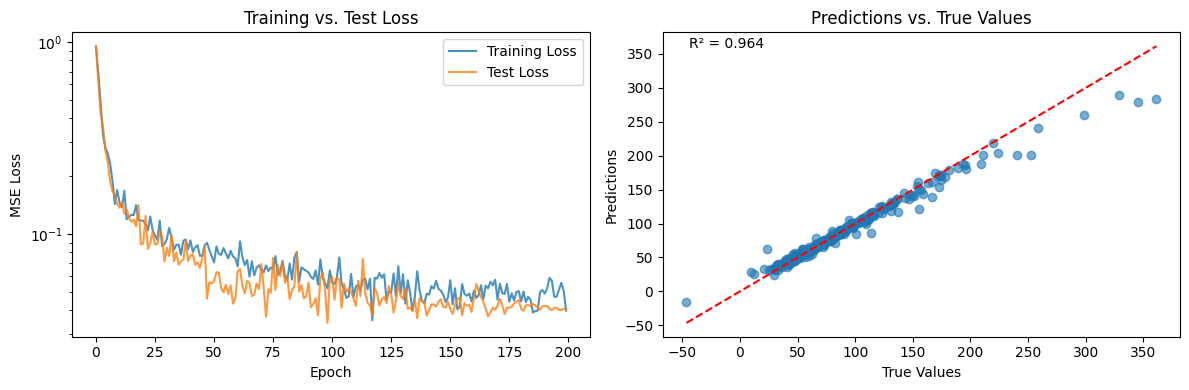


Finaler Test R² Score: 0.9640
Finaler Test MSE: 101.5587


In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', alpha=0.8)
plt.plot(test_loss, label='Test Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.yscale('log')

# Vorhersagen vs. Ground Truth
model.eval()
X_test_scaled = scaler_X.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_scaled)

with torch.no_grad():
    Y_pred_scaled = model(X_test_tensor).numpy()

Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_pred, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')

# R² Score berechnen
r2_score = 1 - np.sum((Y_test - Y_pred)**2) / np.sum((Y_test - Y_test.mean())**2)
plt.text(0.05, 0.95, f'R² = {r2_score:.3f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

print(f"\nFinaler Test R² Score: {r2_score:.4f}")
print(f"Finaler Test MSE: {np.mean((Y_test - Y_pred)**2):.4f}")

In [39]:
from captum.attr import InputXGradient,IntegratedGradients,Saliency
from scipy import stats
from approx_attributes import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

aa = ApproxAttribution(model)
sal = Saliency(model)
IxG = InputXGradient(model)
Ig = IntegratedGradients(model)
ix = IxG.attribute(X_test_tensor).detach()
igt = Ig.attribute(X_test_tensor).detach()
s = sal.attribute(X_test_tensor).detach()
a = aa.grad_x_i_approx(X=X_test_tensor,h=0.1).reshape((300,7))
#print(X_test.shape)
#print(s.detach().numpy().shape)
#print(A[700:].shape)
r = A[700:]
"""
for i in range(7):
    print(i)
    print(s[i,0])
    print(a[i,0])
    print(r[i,0])
"""
print()
print("Saliency")
print("Pearson-Correlation:",np.mean(np.corrcoef(r,s)))
roh,p = stats.spearmanr(r.ravel(), s.ravel())
print("Rank-Correlation:",roh)
print("Gesamt-MSE:", mean_squared_error(r, s))
cos_total = cosine_similarity(r.ravel().reshape(1, -1), s.ravel().reshape(1, -1))[0, 0]
print("Gesamt-Cosine Similarity:", cos_total)
#print(p)

print()
print("Gradient times Input")
print("Pearson-Correlation:",np.mean(np.corrcoef(r,ix)))
roh,p = stats.spearmanr(r.ravel(), ix.ravel())
print("Rank-Correlation:",roh)
print("Gesamt-MSE:", mean_squared_error(r, ix))
cos_total = cosine_similarity(r.ravel().reshape(1, -1), ix.ravel().reshape(1, -1))[0, 0]
print("Gesamt-Cosine Similarity:", cos_total)


print()
print("Integrated Gradients")
print("Pearson-Correlation:",np.mean(np.corrcoef(r,igt)))
roh,p = stats.spearmanr(r.ravel(), igt.ravel())
print("Rank-Correlation:",roh)
print("Gesamt-MSE:", mean_squared_error(r, igt))
cos_total = cosine_similarity(r.ravel().reshape(1, -1), igt.ravel().reshape(1, -1))[0, 0]
print("Gesamt-Cosine Similarity:", cos_total)



/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.12/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)



Saliency
Pearson-Correlation: 0.5849218326197029
Rank-Correlation: 0.48228802010115446
Gesamt-MSE: 635.9319916933899
Gesamt-Cosine Similarity: 0.4336343550072805

Gradient times Input
Pearson-Correlation: 0.2562177400474825
Rank-Correlation: 0.15483305203264786
Gesamt-MSE: 638.6330993574146
Gesamt-Cosine Similarity: 0.1970871018450884

Integrated Gradients
Pearson-Correlation: 0.22416614495355044
Rank-Correlation: 0.0919627649601121
Gesamt-MSE: 641.0266401540692
Gesamt-Cosine Similarity: 0.20204438142546483


/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
